In [36]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from tqdm.keras import TqdmCallback
import pandas as pd
import numpy as np
import os
import shutil
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from metrics import metrics
from ipywidgets import widgets, interact
from IPython.display import clear_output, display
from plotly_dataframe import plot 
from plotly_plt_predictions import plot_predictions
import matplotlib.pyplot as plt
from plot_map import choropleth
from tool_datetime import next_datetimes

In [37]:
# Selection of the gpu.
GPU = [0]
# Set the selected gpu for the usage.
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = ",".join(str(x) for x in GPU)  

# Forecasting - Food Consumpion Score (FCS)

In this notebook, I provide an implementation of the **CNN-LSTM network** capable to forecast the FCS indicator of each provinces of the Yemen country. The idea of this implementation is to consider each province independently predicting the own FCS time-series using as input all the own indicators (FCS included).

Assuming for example to use a *direct* forecast approach to predict some future values of the FCS time-series (denote it as $Z$). Define $P = \{𝐴𝑏𝑦𝑎𝑛, 𝐴𝑑𝑒𝑛, …, 𝑇𝑎𝑖𝑧𝑧\}$  as the ensemble of all the provinces of the Yemen country: each single province $p$ is described by some own time-series (endogenous and exogenous data sources). $\forall p \in P$, we have:

<img src="./images/direct_forecast.gif" width="700">

Each province will get own set of training points $(\vec{X}^p, \vec{y}^p)$ that independently of each other feed their own neural network:

<img src="./images/multiple.png" width="700">

Therefore, there exist 2 possible combinations:

- Recursive forecast & all (or some of them) own indicators as predictors;
- Direct forecast & all (or some of them) own indicators as predictors;

# Data Sources

## Endogenous

In [38]:
# Load the original data (smoothed data) of the second version of fcs indicator released by wfp.
fcs = pd.read_csv("../../../Data Sources/Food Consumption Score (FCS)/time-series/Yemen/wfp_fcs-v2-daily-smooth.csv", header = [0, 1], index_col = 0)
fcs.index.name = "Datetime"
fcs.index = pd.to_datetime(fcs.index)
freq = "D"
fcs.index.freq = freq
fcs.columns.names = ["AdminStrata", "Indicator"]

In [39]:
#plot(fcs, title = "FCS indicator", yaxis = "% of people with poor and borderline FCS", style = "lines")

In [40]:
# Load the second version of the daily data (smooth data) of the rcsi indicator.
rcsi = pd.read_csv("../../../Data Sources/Reduced Coping Strategy Index (rCSI)/time-series/Yemen/wfp_rcsi-v2-daily-smooth.csv", header = [0, 1], index_col = 0)
rcsi.columns.names = ["AdminStrata", "Indicator"]
rcsi.index.name = "Datetime"
rcsi.index = pd.to_datetime(rcsi.index)
freq = "D"
rcsi.index.freq = freq

In [41]:
#plot(rcsi, title = "rCSI indicator", yaxis = "% of people with rCSI >= 19", style = "lines")

In [42]:
# Concatenate two indicators (that are considered the endogenous data sources) into unique dataframe.
endogenous = pd.concat([fcs, rcsi], axis = 1, levels = 0).sort_index(axis = 1)
# Delete the rows (date) that not exist for both indicators.
endogenous.dropna(inplace = True)

In [43]:
#plot(endogenous, title = "Endogenous indicators", style = "lines")

## Exogenous

Now I load some exogenous data sources. This data sources can be analyzed considering a delay time respect to the endogenous data sources: this means that, fixing for example a delay time to 30 days, for a certain date of the fcs indicator will correspond the value of the exogenous data source of 30 days back. This implementation allows to take into consideration the real fact that some data sources are collected with a certain delay; for example the prices of the commodities, in some countries, are released every 30 days. If the shift delay is set to 0 no delay time exist.

In [44]:
# Load the daily data of the price indicator.
price = pd.read_csv("../../../Data Sources/Market prices/time-series/Yemen/wfp_market_price+foodgroup-daily-interpolate-fit.csv", header = [0, 1, 2], index_col = 0)
price.index.name = "Datetime"
price.index = pd.to_datetime(price.index)
freq = "D"
price.index.freq = freq
# Consider the temporal delay.
SHIFT_DELAY = 30
price = price.loc[(price.index >= endogenous.index[0] - SHIFT_DELAY*price.index.freq) & (price.index <= endogenous.index[-1] - SHIFT_DELAY*price.index.freq)]
price.index = endogenous.index
# Delete columns commodity that still have all nan values.
price = price.dropna(axis = 1, how = "all")
# Keep only the food groups taking the mean.
price = price.groupby(level = [0, 1], axis = 1).mean()

In [45]:
#plot(price, title = "Price indicator", yaxis = "Price (YER)", style = "lines")

In [46]:
# Load the daily data of the conflicts indicator.
conflict = pd.read_csv("../../../Data Sources/Conflicts/time-series/Yemen/wfp_conflicts-daily-single-event.csv", header = [0, 1], index_col = 0)
conflict.index.name = "Datetime"
conflict.index = pd.to_datetime(conflict.index)
freq = "D"
conflict.index.freq = freq
# Consider the temporal delay.
SHIFT_DELAY = 0
conflict = conflict.loc[(conflict.index >= endogenous.index[0] - SHIFT_DELAY*conflict.index.freq) & (conflict.index <= endogenous.index[-1] - SHIFT_DELAY*conflict.index.freq)]
conflict.index = endogenous.index

In [47]:
#plot(conflict, title = "Conflict indicator", yaxis = "Fatality", style = "lines")

In [48]:
# Load the daily data of the rainfall indicator.
rainfall = pd.read_csv("../../../Data Sources/Rainfall & Vegetation/time-series/Yemen/wfp_rainfall-daily.csv", header = [0, 1], index_col = 0)
rainfall.index.name = "Datetime"
rainfall.index = pd.to_datetime(rainfall.index)
freq = "D"
rainfall.index.freq = freq
# Consider the temporal delay.
SHIFT_DELAY = 10
rainfall = rainfall.loc[(rainfall.index >= endogenous.index[0] - SHIFT_DELAY*rainfall.index.freq) & (rainfall.index <= endogenous.index[-1] - SHIFT_DELAY*rainfall.index.freq)]
rainfall.index = endogenous.index

In [49]:
#plot(rainfall, title = "Rainfall indicator", yaxis = "Rainfall (mm)", style = "lines")

In [50]:
# Load the daily data of the NDVI indicator.
NDVI = pd.read_csv("../../../Data Sources/Rainfall & Vegetation/time-series/Yemen/wfp_NDVI-daily.csv", header = [0, 1], index_col = 0)
NDVI.index.name = "Datetime"
NDVI.index = pd.to_datetime(NDVI.index)
freq = "D"
NDVI.index.freq = freq
# Consider the temporal delay.
SHIFT_DELAY = 10
NDVI = NDVI.loc[(NDVI.index >= endogenous.index[0] - SHIFT_DELAY*NDVI.index.freq) & (NDVI.index <= endogenous.index[-1] - SHIFT_DELAY*NDVI.index.freq)]
NDVI.index = endogenous.index

In [51]:
#plot(NDVI, title = "NDVI", yaxis = "NDVI", style = "lines")

Complete dataframe merging the endogenous and exogenous data sources. Being all provinces analyzed indipendetly is not necessary to take only common indiators among all the provinces.

In [52]:
# Create the full dataset.
df = pd.concat([endogenous, price, conflict, rainfall, NDVI], axis = 1, levels = 0).sort_index(axis = 1)
# Delete Socotra adminstrata.
df.drop(columns = "Socotra", inplace = True)
df.head()

AdminStrata       Abyan                                                \
Indicator    Condiments Exchange rate        FCS Fatality        Fuel   
Datetime                                                                
2018-08-22   112.975739    505.511930  33.474845      0.0  272.620439   
2018-08-23   114.622055    505.555494  33.294023      0.0  272.582341   
2018-08-24   116.227432    505.541541  33.106557      0.0  272.529332   
2018-08-25   117.791871    505.470073  33.049453      0.0  272.461412   
2018-08-26   119.315373    505.341090  33.259717      0.0  272.378582   

AdminStrata                                                          \
Indicator   Main staples Meet, fish and eggs Milling cost      NDVI   
Datetime                                                              
2018-08-22    341.440394        20804.076445    19.999976  0.100113   
2018-08-23    341.497141        20969.126728    19.999979  0.100113   
2018-08-24    341.575517        21148.392057    19.999983  0.100113   
2018-08-25    341.675523        21341.872432    19.999986  0.100113   
2018-08-26    341.797159        21549.567854    19.999989  0.100113   

AdminStrata              ...               Taizz                         \
Indicator           Oil  ... Meet, fish and eggs Milling cost      NDVI   
Datetime                 ...                                              
2018-08-22   433.146761  ...        17915.330544    19.960488  0.200798   
2018-08-23   432.958616  ...        17934.761362    19.962940  0.200798   
2018-08-24   432.801128  ...        17957.021569    19.966102  0.200798   
2018-08-25   432.674298  ...        17982.111166    19.969975  0.200798   
2018-08-26   432.578124  ...        18010.030153    19.974559  0.200798   

AdminStrata                                                                \
Indicator           Oil      Pulses Rainfall (mm)       Sugar  Vegetables   
Datetime                                                                    
2018-08-22   486.791093  608.232671        1.5854  316.552628  238.000322   
2018-08-23   486.399644  608.774168        1.5854  316.438111  236.708687   
2018-08-24   486.056070  609.313356        1.5854  316.390147  235.545008   
2018-08-25   485.760372  609.850235        1.5854  316.408737  234.509284   
2018-08-26   485.512548  610.384805        1.5854  316.493882  233.601516   

AdminStrata                          
Indicator           Wage       rCSI  
Datetime                             
2018-08-22   4695.106292  50.723749  
2018-08-23   4695.399219  50.411710  
2018-08-24   4695.336799  50.178070  
2018-08-25   4694.919032  50.017246  
2018-08-26   4694.145919  49.923655  

[5 rows x 335 columns]

In [83]:
# If you want to consider only some indicators.
#select = df.columns.get_level_values(1).isin(["FCS"])
#df = df.loc[:, select]
#df.head()

In [54]:
# Define the desired length of the test set.
TEST = 30
# Define the metric to evaluate the model.
ERROR = "MSE"
# Set boolean parameter to perform an optional grid search.
GRID_SEARCH = False
# Fix a random seed if you want to fix the training process of the neural network.
FIX_SEED = False
# Define the datetime frequency of the time-series.
FREQ = df.index.freq

In [55]:
# Recursive forecasting if N_OUT < TEST. If N_OUT = TEST is a direct forecast. Obviously, N_OUT > TEST is not permitted.
N_OUT = 15

if N_OUT == TEST:
    FORECAST = "Direct"
else:
    FORECAST = "Recursive"

In [56]:
# Define the training set and the test set.
train = df[:-TEST]  
test = df[-TEST:]

In [57]:
# If you want to standardize data.
STANDARDIZE = False

In [58]:
# Function that standardize the time-series independently to each other.
means = dict()
stds = dict()
if STANDARDIZE:
    def standardize(serie):
        mean = serie.mean()
        means[serie.name] = mean
        std = serie.std()
        stds[serie.name] = std
        serie = (serie - mean)/std
        return serie

    train = train.apply(standardize)

In [59]:
# Create workspace.
dir = "./output-multiple"
if not os.path.exists(dir):
    os.makedirs(dir)
else:
    shutil.rmtree(dir)           
    os.makedirs(dir)
    
os.makedirs(dir + "/images")
os.makedirs(dir + "/grid_search")
os.makedirs(dir + "/ckpt_trials")
for admin in df.columns.get_level_values(0).unique():
    os.makedirs(dir + "/ckpt_trials/" + admin)

# Create a txt file where I annotate the above chosen parameters.
with open(dir + "/setting.txt", "w") as f:
    f.write("GRID SEARCH: %s \n" % GRID_SEARCH)
    f.write("TEST: %d \n" % TEST)
    f.write("ERROR: %s \n" % ERROR)
    f.write("N_OUT: %d \n" % N_OUT)
    f.write("STANDARDIZE: %d \n" % STANDARDIZE)

# CNN-LSTM

In [60]:
# Convert history into inputs X and outputs y.
def to_supervised(group, n_features, n_input, n_out, validation = False, shuffle = False):
    # Assuming to pass a dataframe 'group' that has a level 0 with the name of the time-series and at level 1 its multivariate time-series (in this case only a variate).
    group.columns = group.columns.droplevel()
    # If the forecast is direct (and involve a dataframe with multivariate time-series) is necessary to specify the name of the variate time-series to predict.
    # If the forecast is recursive (even if there are multivariate time-series) all the variates are recursive predicted.
    if FORECAST == "Direct":
        serie_to_predict = group["FCS"]
        serie_to_predict = serie_to_predict.values
        
    group = group.values

    X, y = list(), list()
    in_start = 0
    # Step over the entire history one time step at a time.
    for _ in range(len(group)):
        # Define the end of the input sequence.
        in_end = in_start + n_input
        out_end = in_end + n_out
        # Ensure we have enough data for this instance.
        if out_end <= len(group):
            x_input = group[in_start:in_end]
            x_input = x_input.reshape((len(x_input), n_features))
            X.append(x_input)
            if FORECAST == "Direct":
                y.append(serie_to_predict[in_end:out_end])
            else:
                y.append(group[in_end:out_end])
        # Move along one time step.
        in_start += 1
      
    # If the validation option is set, I extrapolate some data to use for validation:
    # If shuffle is set to True the data points for the validation phase are taken randomly from the training data.
    # If shuffle is set to False the data points for the validation phase are taken in order: the last points as an holdout validation.
    if validation:
        X = np.array(X)
        y = np.array(y)
        X_train, X_val = train_test_split(X, test_size = 0.1, shuffle = shuffle)
        y_train, y_val = train_test_split(y, test_size = 0.1, shuffle = shuffle)
        return pd.Series({"X_train": np.array(X_train), "y_train": np.array(y_train), 
                          "X_val": np.array(X_val), "y_val": np.array(y_val)})
    else:    
        return pd.Series({"X": np.array(X), "y": np.array(y)})

In [61]:
# Define the model.
def CNN_LSTM(X, y, n_out, n_seq, n_steps, n_filters, n_kernels, n_nodes, n_epochs, batch_size, optimizer, 
             shuffle, adminstrata, n_features, trial = None, fix_seed = False, save = False): 
    # Fix the random seed of the training.
    if fix_seed:
        np.random.seed(0)
        
    # Reshape the input data in order to fed appropriately them to the model.
    X = X.reshape((X.shape[0], n_seq, n_steps, n_features))
    # According to the type of forecast can change the y setting to the model.
    if FORECAST == "Direct":
        n_output = y.shape[1]
    if FORECAST == "Recursive":
        # Flatten output.
        n_output = y.shape[1]*y.shape[2]
        y = y.reshape((y.shape[0], n_output))

    # Define the model.
    model = Sequential()
    model.add(TimeDistributed(Conv1D(n_filters, n_kernels, activation = "relu", input_shape = (None, n_steps, n_features))))
    model.add(TimeDistributed(Conv1D(n_filters, n_kernels, activation = "relu")))
    model.add(TimeDistributed(MaxPooling1D(pool_size = 2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(n_nodes, activation = "relu"))
    model.add(Dense(n_output))
    model.compile(loss = "mse", optimizer = optimizer)

    if save:
        # Define the training checkpoint where saving the results that gives the lower training error for the given attempt (trial) of the given time-series.
        filepath = dir + "/ckpt_trials/" + adminstrata +"/model_" + adminstrata + "_trial%d.h5" % trial 
        checkpoint = ModelCheckpoint(filepath, monitor = "loss", verbose = 0, save_best_only = True, mode = "min")
        callbacks = [checkpoint, TqdmCallback(verbose = 1)]
    else:
        callbacks = [TqdmCallback(verbose = 1)]
        
    # Fit network.
    model.fit(X, y, epochs = n_epochs, batch_size = batch_size, verbose = 0, shuffle = shuffle, callbacks = callbacks)    

    return model

# Optional grid search

In [62]:
# Define the parameters to grid search.
if GRID_SEARCH:
    space = {"n_seq": hp.randint("n_seq", 2, 10), # The number of subsequences within a sample.
             "n_steps": hp.randint("n_steps", 5, 120), # The number of time steps within each subsequence.
             "n_epochs": 1, #hp.randint("n_epochs", 1, 100), # The number of epochs.
             "batch_size": hp.randint("batch_size", 32, 64), # The batch size.
             "n_filters": hp.randint("n_filters", 20, 80), # The number of filters.
             "n_kernels": hp.randint("n_kernels", 1, 10), # The number of time steps considered in each read of the input sequence.
             "n_nodes": hp.randint("n_nodes", 20, 1000), # The number of LSTM units to use in the hidden layer.
             "optimizer": hp.choice("optimizer", ["adam", "rmsprop"]), # The optimizer for the training phase.
             "shuffle": hp.choice("shuffle", [True, False]) # If you want to shuffle the data during training.
            }
else:
    space = {"n_seq": 3,
             "n_steps": 10, 
             "n_epochs": 1,
             "batch_size": 8,
             "n_filters": 64, 
             "n_kernels": 3, 
             "n_nodes": 50, 
             "optimizer": "adam", 
             "shuffle": False
            }

In [63]:
def hyperparameters(space, group):
    # Define the name of the time-series.
    adminstrata = group.name
    # Define the number of features for the selected adminstrata.
    n_features = len(group.columns.get_level_values(1).unique())
    try:        
        print("Grid search for adminstrata:", adminstrata)
        # Create the training samples (X, y).
        n_input = int(space["n_seq"])*int(space["n_steps"])
        data = group.groupby(level = 0, axis = 1).apply(lambda x: to_supervised(x, n_features, n_input, N_OUT, True, space["shuffle"]))        
        # Training data.
        X_train = np.concatenate(data.loc["X_train"])
        X_train = X_train.reshape((X_train.shape[0], n_input, n_features))
        y_train = np.concatenate(data.loc["y_train"])  

        model = CNN_LSTM(X_train, y_train, N_OUT, int(space["n_seq"]), int(space["n_steps"]), int(space["n_filters"]), 
                         int(space["n_kernels"]), int(space["n_nodes"]), int(space["n_epochs"]), int(space["batch_size"]), 
                         space["optimizer"], space["shuffle"], adminstrata, n_features, None, FIX_SEED, False)   

        # Validation data.
        X_val = np.concatenate(data.loc["X_val"])
        X_val = X_val.reshape((X_val.shape[0], n_input, n_features))
        y_val = np.concatenate(data.loc["y_val"])     
        # Reshape the input data in order to fed appropriately them to the model.
        X_val = X_val.reshape((X_val.shape[0], int(space["n_seq"]), int(space["n_steps"]), n_features))
        if FORECAST == "Recursive":
            # Flatten output.
            n_output = y_val.shape[1]*y_val.shape[2]
            y_val = y_val.reshape((y_val.shape[0], n_output))

        pred = model.predict(X_val, batch_size = int(space["batch_size"]), verbose = 0)
        error = metrics(y_val, pred, ERROR).compute()

        # Recursive save results.
        space["loss"] = error
        df_space = pd.DataFrame(space, index = [0])
        filename = dir + "/grid_search/" + adminstrata + ".csv"
        df_space.to_csv(filename, index = False, header = (not os.path.exists(filename)), mode = "a")

        clear_output(wait = True)
        K.clear_session()
    except:
        error = np.inf
        clear_output(wait = True)
        K.clear_session()

    return {"loss": error, "status": STATUS_OK}

In [64]:
def GridSearch(group):
    adminstrata = group.name
    # The searching of the best minimum combination of parameters.
    trials = Trials()
    best = fmin(fn = lambda x: hyperparameters(x, group),
                space = space,
                algo = tpe.suggest,
                max_evals = 2, 
                trials = trials, 
                verbose = False)      
    clear_output(wait = True)
    return best

In [65]:
def NoGridSearch(group):
    adminstrata = group.name
    space["loss"] = 0
    df_space = pd.DataFrame(space, index = [0])
    filename = dir + "/grid_search/" + adminstrata + ".csv"
    df_space.to_csv(filename, index = False)

In [66]:
if GRID_SEARCH:    
    _ = train.groupby(level = 0, axis = 1).apply(GridSearch)
else:
    _ = train.groupby(level = 0, axis = 1).apply(NoGridSearch)

# Forecasting

In [67]:
# The number of simulation to perform during inference phase for each time-serie (being a sthocastic model).
n_trials = 1

In [68]:
figures = dict()
df_prediction = dict()

In [69]:
def quantile_25(x):
    return x.quantile(q = 0.25)

def quantile_75(x):
    return x.quantile(q = 0.75)

In [70]:
# Forecast.
def forecast(group, model_name, n_out, n_seq, n_steps, n_features): 
    n_input = n_seq*n_steps

    if FORECAST == "Recursive":
        iterations = int(np.ceil(TEST/n_out))
        # Load the model.
        model = load_model(model_name, compile = False)
        # Compute prediction.
        for i in range(iterations):
            x_input = group.tail(n_input).values
            x_input = x_input.reshape((1, n_seq, n_steps, n_features))
            y_hats = model.predict(x_input, verbose = 0).flatten()
            y_hats = np.vstack(np.split(y_hats, n_out))
            y_hats = pd.DataFrame(y_hats, index = next_datetimes(group.index[-1], n_out, FREQ), columns = group.columns)
            group = group.append(y_hats)  

        K.clear_session()

        y_hats = group[-(n_out)*iterations:]
        y_hats = y_hats.head(TEST)
    if FORECAST == "Direct":
        # Load the model.
        model = load_model(model_name, compile = False)
        # Compute prediction.
        x_input = group.tail(n_input).values
        x_input = x_input.reshape((1, n_seq, n_steps, n_features))
        y_hats = model.predict(x_input, verbose = 0).flatten()
        y_hats = pd.Series(y_hats, index = next_datetimes(group.index[-1], n_out, FREQ))

        K.clear_session()

    return y_hats

In [71]:
def inference(group, n_trials, n_out, n_seq, n_steps, n_features):
    # Define the name of the current adminstrata.
    adminstrata = group.name
    group = group.droplevel(0, axis = 1)

    df_trials = pd.Series([])
    for trial in range(n_trials):
        # Fit the model.
        y_hats = forecast(group, dir + "/ckpt_trials/" + adminstrata +"/model_" + adminstrata + "_trial%d.h5" % trial, n_out, n_seq, n_steps, n_features) 
        # Inference FCS.
        if FORECAST == "Direct":
            y_hats = pd.DataFrame(y_hats, columns = ["FCS"])
        if FORECAST == "Recursive":
            y_hats = y_hats[["FCS"]]
        y_hats.name = trial
        df_trials = pd.concat([df_trials, y_hats], axis = 1)

    df_trials.dropna(axis = 1, inplace = True)
    results = df_trials.agg([np.mean, quantile_25, quantile_75], axis = "columns")

    # FCS
    serie = group["FCS"]

    if STANDARDIZE:
        serie = serie*stds[(adminstrata, "FCS")] + means[(adminstrata, "FCS")]
        predicted_mean = results["mean"]*stds[(adminstrata, "FCS")] + means[(adminstrata, "FCS")]
        predicted_quantile_25 = results["quantile_25"]*stds[(adminstrata, "FCS")] + means[(adminstrata, "FCS")]
        predicted_quantile_75 = results["quantile_75"]*stds[(adminstrata, "FCS")] + means[(adminstrata, "FCS")]
    else:
        predicted_mean = results["mean"]
        predicted_quantile_25 = results["quantile_25"]
        predicted_quantile_75 = results["quantile_75"]
        
    # The entire original FCS time-series.
    original = pd.concat([serie, test[adminstrata]["FCS"]])
    # Plot of the prediction.
    figure = plot_predictions(original, predicted_mean, predicted_quantile_25, predicted_quantile_75, title = adminstrata, 
                              plotly = False, save = True, dir_to_save = dir + "/images/")
    # Store into dictionary.
    figures[adminstrata] = figure
    df_prediction[adminstrata] = predicted_mean
    
    # Compute the error.
    error = metrics(test[adminstrata]["FCS"], predicted_mean, ERROR).compute()

    return error

In [72]:
def predict(group):   
    # Save the name of the adminstrata.
    adminstrata = group.name
    print("Training & inference for the adminstrata:", adminstrata)
    
    # Save the number of features for the selected time-series adminstrata.
    n_features = len(group.columns.get_level_values(1).unique())
    # Load the best parameters for the selected adminstrata: those obtained using a grid search or those manually set for all the adminstratas.
    filename = dir + "/grid_search/" + adminstrata + ".csv"
    params = pd.read_csv(filename)
    best_params = params.loc[params.loss.idxmin()]  
    
    # Create the training samples (X, y) for the selected adminstrata.
    n_input = int(best_params["n_seq"])*int(best_params["n_steps"])
    data = group.groupby(level = 0, axis = 1).apply(lambda x: to_supervised(x, n_features, n_input, N_OUT, False))   
    
    # New training data: training data + validation data.
    X = np.concatenate(data.loc["X"])
    X = X.reshape((X.shape[0], n_input, n_features))
    y = np.concatenate(data.loc["y"])    

    for trial in range(n_trials):
        print("--- Trial %d/%d" % (trial + 1, n_trials))
        model = CNN_LSTM(X, y, N_OUT, int(best_params["n_seq"]), int(best_params["n_steps"]), int(best_params["n_filters"]), 
                         int(best_params["n_kernels"]), int(best_params["n_nodes"]), int(best_params["n_epochs"]), 
                         int(best_params["batch_size"]), best_params["optimizer"], best_params["shuffle"], adminstrata, 
                         n_features, trial, FIX_SEED, True)            
        clear_output(wait = True)
        K.clear_session()
    
    errors = group.groupby(level = 0, axis = 1).apply(lambda x: inference(x, n_trials, N_OUT, int(best_params["n_seq"]), 
                                                                          int(best_params["n_steps"]), n_features))
    
    
    return errors.values[0]

In [73]:
errors = train.groupby(level = 0, axis = 1).apply(predict)

Training & inference for the adminstrata: Taizz
--- Trial 1/1


In [74]:
errors.mean()

103.13597524371376

In [75]:
def plot_prediction(name):
    fig = figures[name]
    display(fig)

In [76]:
w = widgets.Dropdown(options = df.columns.get_level_values(0).unique(), description = df.columns.get_level_values(0).name, 
                     disabled = False)
p = interact(plot_prediction, name = w)

interactive(children=(Dropdown(description='AdminStrata', options=('Abyan', 'Aden', 'Al Bayda', "Al Dhale'e", …

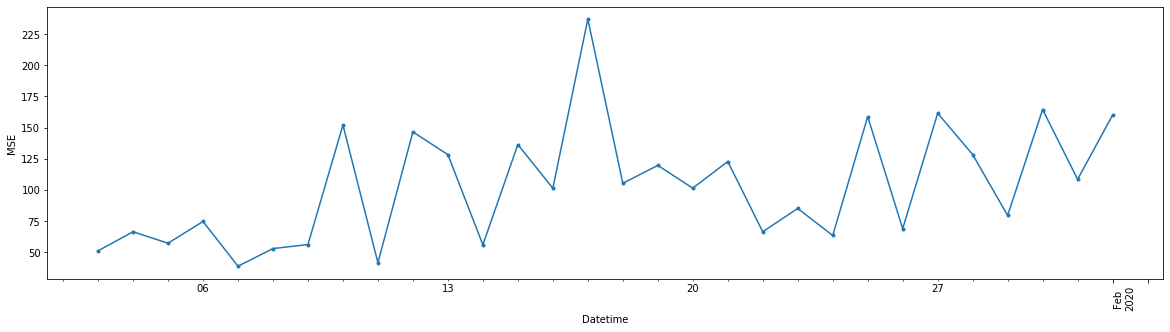

In [77]:
# Plot the mean error in function of the time.
def error_time(serie):
    date = serie.name
    pred_time = pd.DataFrame(df_prediction).transpose()[date]
    error = metrics(serie, pred_time, ERROR).compute()
    return error
    
select = test.columns.get_level_values(1).isin(["FCS"])
prediction_time = test.loc[:, select].transpose().apply(error_time)

# Show plot.
f = plt.figure(figsize = (20, 5))
prediction_time.plot(ax = f.gca(), style = ".-")
plt.ylabel(ERROR)
plt.xlabel("Datetime")
plt.xticks(rotation = 90)
plt.autoscale()
plt.show()

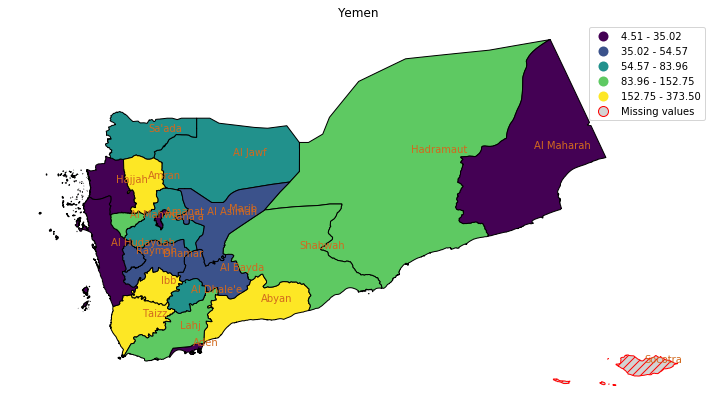

In [78]:
choropleth("Yemen", df.columns.get_level_values(0).unique(), errors, annotation = True, figsize = (15, 7))

In [79]:
# Save the results dataframe.
predictions = pd.DataFrame(df_prediction)
predictions.columns = pd.MultiIndex.from_product([predictions.columns, ["FCS"]])
predictions.columns.names = ["AdminStrata", "Indicator"]

In [82]:
test.to_csv(dir + "/test.csv")
predictions.to_csv(dir + "/CNN-LSTM.csv")